In [1]:
from voc_dataset import VOCDetection
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
from lib.augmentations import SSDAugmentation
import cv2
from lib.utils import nms
import matplotlib.pyplot as plt
from lib.utils import *


%matplotlib inline


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

## A image you want to detect

In [3]:
image = 'images/000009.jpg'

In [4]:
def preproc_for_test(image, insize, mean):
    image = cv2.resize(image, (insize, insize))
    image = image.astype(np.float32)
    image -= mean
    image = image[:, :, (2, 1, 0)]
    
    return torch.from_numpy(image).permute(2, 0, 1)

In [5]:
multibox_encoder = MultiBoxEncoder(opt)

In [6]:
src = cv2.imread(image, cv2.IMREAD_COLOR)

In [7]:
image = preproc_for_test(src, opt.min_size, opt.mean)

In [8]:
model = SSD(opt.num_classes, opt.anchor_num)

## load weights

In [9]:
state_dict = torch.load('weights/latest.pth', map_location='cpu')

In [10]:
model.load_state_dict(state_dict)

## predict

In [11]:
with torch.no_grad():
    loc, conf = model(image.unsqueeze(0))

In [12]:
loc = loc[0]
conf = conf[0]

In [13]:
conf = F.softmax(conf, dim=1)

In [14]:
conf = conf.numpy()
loc = loc.numpy()

## decode location

In [15]:
decode_loc = multibox_encoder.decode(loc)

## detect

In [16]:
gt_labels, gt_conf, gt_locations = detect(decode_loc, conf, src.shape[1], src.shape[0], 0.5, 0.5)

In [17]:
rec = draw_rectangle(src, gt_labels, gt_conf, gt_locations, VOC_CLASSES)

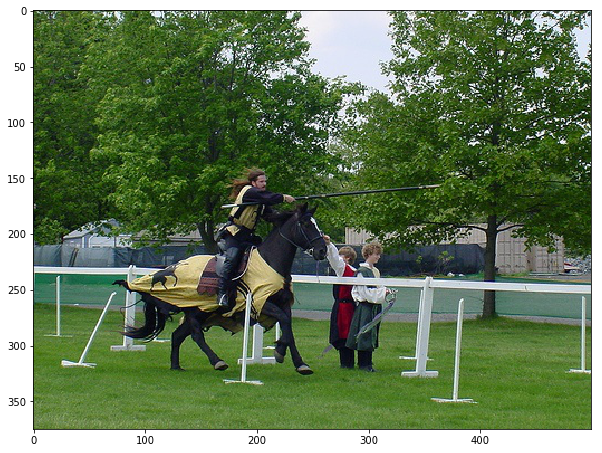

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(src[:, :, ::-1])

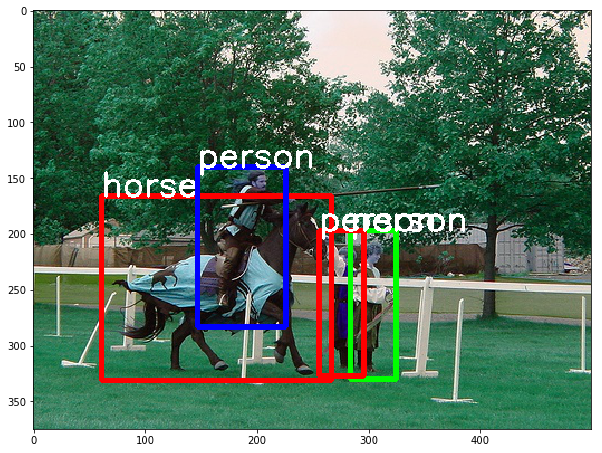

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(rec)